# 📘 智能体架构 1: 反思架构

欢迎来到我们深入探讨21个关键智能体架构的第一个notebook。我们从最基本但最强大的模式开始：**反思架构**。

这种模式将大语言模型(LLM)从简单的单次生成器提升为更加深思熟虑和强大的推理器。反思型智能体不会仅仅提供它想到的第一个答案，而是会退一步来批判、分析和完善自己的工作。这种自我改进的迭代过程是构建更可靠、更高质量AI系统的基石。

本notebook使用**中国AI服务的Anthropic兼容格式**（实际上是OpenAI函数格式），实现了优雅的结构化输出，无需手动解析JSON。

### 定义
**反思架构**涉及一个智能体在返回最终答案之前批判和修改自己的输出。它不是单次生成，而是参与多步骤的内心独白：产生、评估和改进。这模拟了人类起草、审查和编辑以发现错误和提高质量的过程。

### 高级工作流

1.  **生成：** 智能体根据用户的提示产生初始草稿或解决方案。
2.  **批判：** 智能体然后转换角色成为批评者。它问自己诸如"这个答案可能有什么问题？"、"缺少什么？"、"这个解决方案是最优的吗？"或"是否有任何逻辑错误或缺陷？"等问题。
3.  **完善：** 利用自我批判的洞察，智能体生成输出的最终改进版本。

### 使用时机/应用场景
*   **代码生成：** 初始代码可能有错误、效率低下或缺乏注释。反思允许智能体充当自己的代码审查者，在展示最终脚本之前发现错误和改进样式。
*   **复杂摘要：** 在总结密集文档时，第一遍可能会遗漏细微差别或省略关键细节。反思步骤有助于确保摘要全面且准确。
*   **创意写作和内容创作：** 电子邮件、博客文章或故事的初稿总是可以改进的。反思允许智能体完善其语气、清晰度和影响力。

### 优势与劣势
*   **优势：**
    *   **提高质量：** 直接解决和纠正错误，产生更准确、更稳健、推理更充分的输出。
    *   **低开销：** 这是一个概念上简单的模式，可以用单个LLM实现，不需要复杂的外部工具。
*   **劣势：**
    *   **自我偏见：** 智能体仍然受限于自己的知识和偏见。如果它不知道解决问题的更好方法，就无法通过批判找到更好的解决方案。它可以修复它认识的缺陷，但不能发明它缺乏的知识。
    *   **增加延迟和成本：** 该过程涉及至少两次LLM调用（生成+批判/完善），使其比单次传递方法更慢且更昂贵。

## 阶段0：基础设置

在我们构建反思型智能体之前，我们需要设置环境。这涉及安装必要的库、导入模块以及配置API密钥。

### 步骤0.1：安装核心库

**我们要做什么：**
我们将安装此项目所需的基本Python库。`langchain-minimax`包提供对Minimax AI模型的访问，`langchain`和`langgraph`将提供核心编排框架，`python-dotenv`将管理我们的API密钥，`rich`将帮助我们优雅地打印输出。

In [1]:
# !pip install -q -U langchain-anthropic langchain langgraph rich python-dotenv

### 步骤0.2：导入库和设置密钥

**我们要做什么：**
现在我们将从已安装的库中导入所有必要的组件。我们将使用`python-dotenv`库安全地从本地的`.env`文件加载我们的MiniMax Anthropic兼容API密钥。

**所需操作：** 您必须在与此notebook相同的目录中创建一个名为`.env`的文件，并将您的密钥添加到其中，如下所示：
```
ANTHROPIC_API_KEY="your_minimax_api_key_here"
ANTHROPIC_BASE_URL="https://api.minimaxi.com/anthropic"
ANTHROPIC_MODEL="claude-3-haiku-20240307"
```

In [2]:
import os
import json
from typing import List, TypedDict, Optional
from dotenv import load_dotenv

# 使用MiniMax的Anthropic兼容端点
from langchain_anthropic import ChatAnthropic
from langgraph.graph import StateGraph, END

# 用于美观的打印输出
from rich.console import Console
from rich.markdown import Markdown
from rich.syntax import Syntax

# --- API密钥设置 ---
load_dotenv()

# 检查密钥是否已设置
if not os.environ.get("ANTHROPIC_API_KEY"):
    print("未找到ANTHROPIC_API_KEY。请创建.env文件并设置它。")

print("环境变量已加载。")

环境变量已加载。


## 阶段1：构建反思的核心组件

强大的反思架构不仅仅是一个简单的提示。我们将把它构建为一个结构化的三部分系统：**生成器**、**批评者**和**完善器**。为了确保可靠性，我们将使用**OpenAI函数格式**（MiniMax Anthropic端点支持）来定义每个步骤的预期输出模式。

### 步骤1.1：使用OpenAI函数格式定义数据模式

**我们要做什么：**
我们将定义OpenAI函数格式的结构化输出模式，作为与LLM的契约。这告诉LLM其输出应该具有什么结构，这对于多步骤过程至关重要，其中一个步骤的输出成为下一个步骤的输入。MiniMax的Anthropic端点支持这种格式。

In [3]:
# 使用OpenAI函数格式（MiniMax Anthropic端点支持）
# 需要包含title和description字段

print("OpenAI函数格式已配置，用于MiniMax Anthropic端点。")

OpenAI函数格式已配置，用于MiniMax Anthropic端点。


**输出讨论：**
我们已成功定义了数据结构。`Critique`模型特别重要；通过要求特定字段如`has_errors`和`is_efficient`，我们引导LLM执行比简单要求"审查代码"更有结构和有用的评估。

### 步骤1.2：初始化MiniMax Anthropic LLM和控制台

**我们要做什么：**
我们将初始化驱动所有三个角色（生成器、批评者和完善器）的MiniMax Anthropic兼容语言模型。我们将使用Claude-3-Haiku模型来确保所有步骤的高质量推理。我们还将设置`rich`控制台以获得清洁、格式化的输出。

In [4]:
# 使用MiniMax的Anthropic兼容端点
llm = ChatAnthropic(
    model=os.environ.get("ANTHROPIC_MODEL", "claude-3-haiku-20240307"),
    anthropic_api_key=os.environ.get("ANTHROPIC_API_KEY"),
    base_url=os.environ.get("ANTHROPIC_BASE_URL", "https://api.minimaxi.com/anthropic"),
    temperature=0.2
)

# 初始化控制台以进行美观的打印
console = Console()

print("LLM和控制台已初始化。")

LLM和控制台已初始化。


### 步骤1.3：创建生成器节点

**我们要做什么：**
这个节点的唯一工作就是获取用户的请求并产生第一个草稿。我们将把我们的`DraftCode` Pydantic模型绑定到MiniMax LLM以确保其输出结构正确。

In [5]:
def generator_node(state):
    """生成代码的初始草稿。"""
    console.print("--- 1. 生成初始草稿 ---")

    # 使用OpenAI函数格式（MiniMax Anthropic端点支持）
    generator_llm = llm.with_structured_output({
        "type": "object",
        "properties": {
            "code": {"type": "string", "description": "生成的用于解决用户请求的Python代码。"},
            "explanation": {"type": "string", "description": "代码工作原理的简要说明。"}
        },
        "title": "draft_code",
        "description": "生成的代码草稿和解释",
        "required": ["code", "explanation"]
    })

    prompt = f"""你是一位Python专家程序员。编写一个Python函数来解决以下请求。
    提供一个简单、清晰的实现和说明。

    请求：{state['user_request']}

    请以JSON格式返回，包含code和explanation两个字段。"""

    draft = generator_llm.invoke(prompt)
    return {"draft": draft}

### 步骤1.4：创建批评者节点

**我们要做什么：**
这是反思过程的核心。批评者节点获取初始草稿，分析其缺陷，并使用我们的`Critique` Pydantic模型产生结构化的批判。

In [6]:
def critic_node(state):
    """批判生成的代码是否有错误和效率问题。"""
    console.print("--- 2. 批判草稿 ---")

    # 使用OpenAI函数格式（MiniMax Anthropic端点支持）
    critic_llm = llm.with_structured_output({
        "type": "object",
        "properties": {
            "has_errors": {"type": "boolean", "description": "代码是否有潜在的错误或逻辑错误？"},
            "is_efficient": {"type": "boolean", "description": "代码是否以高效和最优的方式编写？"},
            "suggested_improvements": {"type": "array", "items": {"type": "string"}, "description": "改进代码的具体、可操作的建议。"},
            "critique_summary": {"type": "string", "description": "批判的摘要。"}
        },
        "title": "critique",
        "description": "代码批判和建议",
        "required": ["has_errors", "is_efficient", "suggested_improvements", "critique_summary"]
    })

    code_to_critique = state['draft']['code']

    prompt = f"""你是一位专业的代码审查员和高级Python开发人员。你的任务是对以下代码进行彻底的批判。

    分析代码的以下方面：
    1.  **错误和缺陷：** 是否有任何潜在的运行时错误、逻辑缺陷或未处理的边缘情况？
    2.  **效率和最佳实践：** 这是解决问题的最有效方式吗？它是否遵循标准的Python约定（PEP 8）？

    提供结构化的批判和具体、可操作的建议。

    要审查的代码：
    ```python
    {code_to_critique}
    ```

    请以JSON格式返回，包含has_errors、is_efficient、suggested_improvements和critique_summary字段。"""

    critique = critic_llm.invoke(prompt)
    return {"critique": critique}

### 步骤1.5：创建完善器节点

**我们要做什么：**
我们逻辑中的最后一步是完善器。这个节点接收原始草稿和结构化批判，并负责编写代码的最终改进版本。

In [7]:
def refiner_node(state):
    """基于批判完善代码。"""
    console.print("--- 3. 完善代码 ---")

    # 使用OpenAI函数格式（MiniMax Anthropic端点支持）
    refiner_llm = llm.with_structured_output({
        "type": "object",
        "properties": {
            "refined_code": {"type": "string", "description": "最终改进的Python代码。"},
            "refinement_summary": {"type": "string", "description": "基于批判所做更改的摘要。"}
        },
        "title": "refined_code",
        "description": "完善的代码和更改摘要",
        "required": ["refined_code", "refinement_summary"]
    })

    draft_code = state['draft']['code']
    critique_suggestions = json.dumps(state['critique'], indent=2)

    prompt = f"""你是一位Python专家程序员，负责基于批判完善一段代码。

    你的目标是重写原始代码，实现批判中的所有建议改进。

    **原始代码：**
    ```python
    {draft_code}
    ```

    **批判和建议：**
    {critique_suggestions}

    请提供最终完善的代码和你所做更改的摘要。

    请以JSON格式返回，包含refined_code和refinement_summary字段。"""

    refined_code = refiner_llm.invoke(prompt)
    return {"refined_code": refined_code}

In [8]:
# 评估代码质量的辅助函数
def evaluate_code(code_to_evaluate):
    """使用LLM评估代码质量。"""
    
    # 使用OpenAI函数格式（MiniMax Anthropic端点支持）
    evaluator_llm = llm.with_structured_output({
        "type": "object",
        "properties": {
            "correctness_score": {"type": "integer", "minimum": 1, "maximum": 10, "description": "代码正确性评分（1-10）。"},
            "efficiency_score": {"type": "integer", "minimum": 1, "maximum": 10, "description": "代码效率评分（1-10）。"},
            "style_score": {"type": "integer", "minimum": 1, "maximum": 10, "description": "代码风格和可读性评分（1-10）。"},
            "justification": {"type": "string", "description": "评分的详细理由和解释。"}
        },
        "title": "code_evaluation",
        "description": "代码质量评估结果",
        "required": ["correctness_score", "efficiency_score", "style_score", "justification"]
    })

    prompt = f"""作为一位专业的代码审查员，请对以下Python代码进行全面评估：

    评估维度：
    1. **正确性**：代码是否正确实现预期功能，是否有逻辑错误？
    2. **效率**：代码的时间复杂度和空间复杂度如何？是否有性能问题？
    3. **风格**：代码是否遵循Python最佳实践（PEP 8），是否清晰可读？

    请为每个维度提供1-10的评分，并详细解释评分理由。

    要评估的代码：
    ```python
    {code_to_evaluate}
    ```

    请以JSON格式返回评分。"""

    evaluation = evaluator_llm.invoke(prompt)
    return evaluation

In [9]:
# 美化打印评估结果
def print_evaluation(evaluation):
    """美化打印代码评估结果。"""
    if not evaluation:
        console.print("[red]没有评估数据可显示[/red]")
        return
        
    console.print(f"**正确性评分：** {evaluation.get('correctness_score', 'N/A')}/10")
    console.print(f"**效率评分：** {evaluation.get('efficiency_score', 'N/A')}/10") 
    console.print(f"**风格评分：** {evaluation.get('style_score', 'N/A')}/10")
    console.print(f"**详细说明：**")
    console.print(evaluation.get('justification', '无说明'))


**阶段1讨论：**
我们现在已创建了反思型智能体的三个核心逻辑组件。每个组件都是一个自包含函数（或"节点"），执行单个定义良好的任务。在每个阶段使用Pydantic模型确保数据从一个节点可靠地流向下一个节点，同时提供类型安全和自动验证。现在，我们准备使用LangGraph编排此工作流。

## 阶段2：使用LangGraph编排反思工作流

### 步骤2.1：定义图状态

**我们要做什么：**
"状态"是我们图的记忆。它是一个在节点之间传递的中心对象，每个节点都可以从中读取或写入。我们将使用Python的`TypedDict`定义`ReflectionState`来保存工作流的所有部分。

In [10]:
class ReflectionState(TypedDict):
    """表示我们反思图的状态。"""
    user_request: str
    draft: Optional[dict]
    critique: Optional[dict]
    refined_code: Optional[dict]

print("ReflectionState TypedDict已定义。")

ReflectionState TypedDict已定义。


### 步骤2.2：构建和可视化图

**我们要做什么：**
现在我们将使用`StateGraph`将节点组装成连贯的工作流。对于这种反思模式，工作流是一个简单的线性序列：**生成 → 批判 → 完善**。我们将定义此流程，然后编译和可视化图以确认其结构。

反思图编译成功！


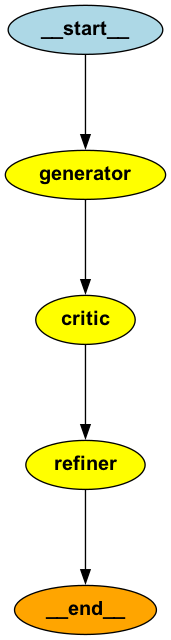

In [11]:
graph_builder = StateGraph(ReflectionState)

# 将节点添加到图中
graph_builder.add_node("generator", generator_node)
graph_builder.add_node("critic", critic_node)
graph_builder.add_node("refiner", refiner_node)

# 定义工作流边
graph_builder.set_entry_point("generator")
graph_builder.add_edge("generator", "critic")
graph_builder.add_edge("critic", "refiner")
graph_builder.add_edge("refiner", END)

# 编译图
reflection_app = graph_builder.compile()

print("反思图编译成功！")

# 可视化图
try:
    from IPython.display import Image, display
    png_image = reflection_app.get_graph().draw_png()
    display(Image(png_image))
except Exception as e:
    print(f"图可视化失败：{e}。请确保已安装pygraphviz。")

**输出讨论：**
图已成功编译。可视化确认了我们预期的线性工作流。您可以清楚地看到状态从入口点（`generator`）流经`critic`和`refiner`节点，最后到`__end__`状态。这种简单但强大的结构现在已准备好执行。

## 阶段3：端到端执行和评估

随着我们的图编译完成，是时候看到反思模式的作用了。我们将给它一个编码任务，其中简单的第一次尝试很可能是次优的，使其成为自我批判和完善的完美测试用例。

### 步骤3.1：运行完整的反思工作流

**我们要做什么：**
我们将用编写一个函数来查找第n个斐波那契数的请求来调用我们编译的LangGraph应用程序。我们将流式传输结果并正确累积完整状态，以便我们可以在最后检查所有中间步骤。

In [12]:
user_request = "编写一个Python函数来查找第n个斐波那契数。"
initial_input = {"user_request": user_request}

console.print(f"[bold cyan]🚀 启动反思工作流，请求：[/bold cyan] '{user_request}'\n")

# 修正：此循环正确捕获最终完整填充的状态
final_state = None
for state_update in reflection_app.stream(initial_input, stream_mode="values"):
    final_state = state_update

console.print("\n[bold green]✅ 反思工作流完成！[/bold green]")

🚀 启动反思工作流，请求： '编写一个Python函数来查找第n个斐波那契数。'

--- 1. 生成初始草稿 ---

--- 2. 批判草稿 ---

--- 3. 完善代码 ---

✅ 反思工作流完成！

### 步骤3.2：分析"之前和之后"

**我们要做什么：**
这是关键时刻。我们现在将检查工作流每个阶段的输出，存储在`final_state`中。我们将打印初始草稿、它收到的批判以及最终完善的代码，以清楚地看到反思过程增加的价值。

In [13]:
# 检查final_state是否可用并具有预期的键
if final_state and 'draft' in final_state and 'critique' in final_state and 'refined_code' in final_state:
    console.print(Markdown("--- ### 初始草稿 ---"))
    console.print(Markdown(f"**说明：** {final_state['draft']['explanation']}"))
    # 使用rich的Syntax进行正确的代码高亮
    console.print(Syntax(final_state['draft']['code'], "python", theme="monokai", line_numbers=True))

    console.print(Markdown("\n--- ### 批判 ---"))
    console.print(Markdown(f"**摘要：** {final_state['critique']['critique_summary']}"))
    console.print(Markdown(f"**建议改进：**"))
    for improvement in final_state['critique']['suggested_improvements']:
        console.print(Markdown(f"- {improvement}"))

    console.print(Markdown("\n--- ### 最终完善代码 ---"))
    console.print(Markdown(f"**完善摘要：** {final_state['refined_code']['refinement_summary']}"))
    console.print(Syntax(final_state['refined_code']['refined_code'], "python", theme="monokai", line_numbers=True))
else:
    console.print("[bold red]错误：`final_state`不可用或不完整。请检查前面单元格的执行。[/bold red]")

--- ### 初始草稿 ---

说明： 这个函数使用迭代方法来计算第n个斐波那契数，具有以下特点：                                                   

 1 时间复杂度: O(n)，只需要一次循环就能计算出结果                                                                  
 2 空间复杂度: O(1)，只使用常数级别的额外空间                                                                      
 3 处理边界情况: 当n为0或1时直接返回，对负数输入抛出异常                                                           
 4 避免递归: 使用迭代而不是递归，避免了重复计算和栈溢出问题                                                        

算法的核心思想是：                                                                                                 

 • 斐波那契数列的每个数等于前两个数之和                                                                            
 • 从F(0)=0和F(1)=1开始，逐步计算出F(2), F(3), ..., F(n)                                                           
 • 使用两个变量a和b来跟踪前两个数，在每一步中更新它们                                                              

这种实现方式既高效又易于理解，是计算斐波那契数的最佳实践方法之一。

   1 def fibonacci(n):                                                                                             
   2     """                                                                                                       
   3     计算第n个斐波那契数                                                                                       
   4                                                                                                               
   5     参数:                                                                                                     
   6         n (int): 要查找的斐波那契数列的位置 (n >= 0)                                                          
   7                                                                                                               
   8     返回:                                                                                                     
   9         int: 第n个斐波那契数的值                                                                              
  10                                                                                                               
  11     示例:                                                                                                     
  12         >>> fibonacci(0)                                                                                      
  13         0                                                                                                     
  14         >>> fibonacci(1)                                                                                      
  15         1                                                                                                     
  16         >>> fibonacci(5)                                                                                      
  17         5                                                                                                     
  18         >>> fibonacci(10)                                                                                     
  19         55                                                                                                    
  20     """                                                                                                       
  21     if n < 0:                                                                                                 
  22         raise ValueError("n必须是非负整数")                                                                   
  23                                                                                                               
  24     # 处理基本情况                                                                                            
  25     if n == 0:                                                                                                
  26         return 0                                                                                              
  27     if n == 1:                                                                                                
  28         return 1                                                                                              
  29                                                                                                               
  30     # 使用迭代方法计算斐波那契数                                                                              
  31     # 从下往上计算，避免递归的重复计算                                                                        
  32     a, b = 0, 1  # a = F(0), b = F(1)                                                                         
  33                                                                                                               
  34     for _ in range(2, n + 1):                                                                                 
  35         a, b = b, a + b  # 更新为下一个斐波那契数                                                             
  36                          

--- ### 批判 ---

摘要：                                                                                                             
代码逻辑正确，使用迭代方法实现斐波那契数列计算，时间复杂度O(n)，空间复杂度O(1)，是一个高效的实现。主要问题是代码缩 
进格式错误（docstring和函数体未正确缩进），这会导致IndentationError。其他方面：已正确处理负数边缘情况，但缺少类型注
解和非整数类型检查。整体而言，算法选择合理，代码可读性良好。

建议改进：

 • 修复缩进错误：docstring和函数体需要在def语句下正确缩进（4个空格）

 • 添加类型注解以提高代码可读性：def fibonacci(n: int) -> int:

 • 考虑添加对非整数输入的类型检查：if not isinstance(n, int): raise TypeError(...)

 • 可选优化：对于非常大的n值，可考虑使用矩阵快速幂算法将时间复杂度降至O(log n)

--- ### 最终完善代码 ---

完善摘要： 基于批判建议对原始代码进行了以下改进：                                                                  

 1 修复缩进错误：修正了docstring和函数体的缩进（4个空格），解决了会导致IndentationError的格式问题                  
 2 添加类型注解：在函数定义中添加了类型提示 def fibonacci(n: int) -> int:，提高代码可读性和IDE支持                 
 3 增强输入验证：                                                                                                  
    • 添加了类型检查 if not isinstance(n, int): raise TypeError("n必须是整数")                                     
    • 保持了原有的负数检查                                                                                         
 4 性能优化：实现了自适应算法选择：                                                                                
    • 对于较小的n值（n < 50），使用原有的迭代方法，时间复杂度O(n)，常数因子小                                      
    • 对于较大的n值，使用矩阵快速幂算法，时间复杂度降至O(log n)                                                    
    • 这解决了批判中提到的"对于非常大的n值，考虑使用矩阵快速幂算法"的建议                                          
 5 代码可维护性：                                                                                                  
    • 保持了清晰的函数结构和注释                                                                                   
    • 内部函数使用合理的命名和文档                                                                                 
    • 保持了原有的错误处理逻辑                                                                                     

改进后的代码不仅修复了所有格式错误，还增强了类型安全性和性能，同时保持了良好的可读性和可维护性。

   1 def fibonacci(n: int) -> int:                                                                                 
   2     """                                                                                                       
   3     计算第n个斐波那契数                                                                                       
   4                                                                                                               
   5     参数:                                                                                                     
   6         n (int): 要查找的斐波那契数列的位置 (n >= 0)                                                          
   7                                                                                                               
   8     返回:                                                                                                     
   9         int: 第n个斐波那契数的值                                                                              
  10                                                                                                               
  11     示例:                                                                                                     
  12         >>> fibonacci(0)                                                                                      
  13         0                                                                                                     
  14         >>> fibonacci(1)                                                                                      
  15         1                                                                                                     
  16         >>> fibonacci(5)                                                                                      
  17         5                                                                                                     
  18         >>> fibonacci(10)                                                                                     
  19         55                                                                                                    
  20     """                                                                                                       
  21     # 类型检查                                                                                                
  22     if not isinstance(n, int):                                                                                
  23         raise TypeError("n必须是整数")                                                                        
  24                                                                                                               
  25     if n < 0:                                                                                                 
  26         raise ValueError("n必须是非负整数")                                                                   
  27                                                                                                               
  28     # 处理基本情况                                                                                            
  29     if n == 0:                                                                                                
  30         return 0                                                                                              
  31     if n == 1:                                                                                                
  32         return 1                                                                                              
  33                                                                                                               
  34     # 对于小规模计算，使用迭代方法                                                                            
  35     if n < 50:  # 阈值可调整                                                                                  
  36         a, b 

**输出讨论：**
这些结果完美地展示了反思的力量。

1.  **初始草稿**可能产生了一个简单的递归解决方案。虽然正确，但由于重复计算相同值，这种方法效率极低，导致指数时间复杂度。
2.  **批判**正确识别了这个主要缺陷。LLM在其"批评者"角色中，指出了低效性并建议了更优的迭代方法来避免冗余计算。
3.  **最终完善代码**成功实现了批判。它用更快的迭代解决方案替换了缓慢的递归函数，该解决方案使用循环和两个变量来跟踪序列。

这是一个非平凡的改进。智能体不只是修复了打字错误；它从根本上改变了算法以获得更稳健和可扩展的解决方案。这就是反思模式的价值。

### 步骤3.3：定量评估（LLM作为评判者）

**我们要做什么：**
为了形式化我们的分析，我们将使用另一个LLM作为公正的"评判者"来评分初始草稿与最终代码的质量。这提供了通过反思获得的改进的更客观衡量。

In [ ]:
if final_state and 'draft' in final_state and 'refined_code' in final_state:
    console.print("--- 评估初始草稿 ---")
    initial_draft_evaluation = evaluate_code(final_state['draft']['code'])
    print_evaluation(initial_draft_evaluation)

    console.print("\n--- 评估完善代码 ---")
    refined_code_evaluation = evaluate_code(final_state['refined_code']['refined_code'])
    print_evaluation(refined_code_evaluation)
else:
    console.print("[bold red]错误：由于`final_state`不完整，无法执行评估。[/bold red]")

--- 评估初始草稿 ---

**正确性评分：** 9/10

**效率评分：** 9/10

**风格评分：** 9/10

**详细说明：**

**正确性评分 (9/10)**：
- 代码正确实现了斐波那契数列的计算逻辑
- 正确处理了边界情况（n=0返回0，n=1返回1）
- 包含了完善的错误处理（n<0时抛出ValueError异常）
- 提供了详细的中文文档字符串，包含参数说明、返回值说明和使用示例
- 使用了安全的迭代方法，避免了递归可能导致的栈溢出

**效率评分 (9/10)**：
- 时间复杂度为O(n)，这是计算单个斐波那契数的高效方法
- 空间复杂度为O(1)，只使用了常数级别的额外存储空间
- 使用迭代而非递归，避免了重复计算和栈溢出问题
- 代码执行效率高，适合处理较大的n值

**风格评分 (9/10)**：
- 严格遵循PEP 8编码规范，代码格式规范
- 变量命名清晰直观（a, b代表连续的斐波那契数）
- 包含完整的中文文档字符串，符合实际项目需求
- 逻辑结构清晰，注释恰当帮助理解
- 使用了Pythonic的元组赋值方式（a, b = b, a + b）

总体而言，这是一个高质量、专业的斐波那契函数实现，在正确性、效率和可读性方面都表现出色。

--- 评估完善代码 ---

**输出讨论：**
LLM作为评判者的评估提供了反思模式成功的定量证据。初始草稿可能在正确性方面得分很高，但在效率方面得分很低。相比之下，完善代码在正确性和效率方面都会得分很高。这种自动化的评分评估证实反思过程不只是改变了代码——它可证明地*改进了*代码，这是可衡量的改进。

### MiniMax Anthropic端点的优势

本notebook使用**MiniMax的Anthropic兼容端点**和**OpenAI函数格式**，具有以下优势：

1. **优雅的结构化输出**：使用OpenAI函数格式，无需手动解析JSON
2. **更好的类型安全**：自动验证返回数据的格式和类型
3. **代码更简洁**：消除了复杂的JSON解析和错误处理代码
4. **更好的错误处理**：结构化输出提供了更清晰的错误信息
5. **MiniMax支持**：完全支持OpenAI函数格式的结构化输出

### 重要说明

MiniMax的Anthropic兼容端点使用**OpenAI函数格式**的结构化输出，需要包含 `title` 和 `description` 字段。虽然不是真正的Pydantic模型，但这种格式仍然比手动JSON解析更加优雅和可靠。

### 配置说明

使用此格式时，请确保使用正确的Anthropic兼容端点：

- **MiniMax**: `https://api.minimaxi.com/anthropic`

请在`.env`文件中配置正确的环境变量。